# Road Traffic Sign Classify Model

The work below attempt to create/evaluate machine learning models and to train a model to classify images of European road traffic signs. [here]().

* There are roughly 3500 instances of labelled sign in the dataset.
* There are several models with different performances considerated in this work.
* More details about the analysis/evaluation of the dataset and the models can be found in this [analysis report](https://road-traffic-sign-classify.notebook.us-east-1.sagemaker.aws/lab/tree/road-traffic-sign-classify/Report.docx).

>Author: ***Daniel Dao***

<hr size="5" />

## Table of Contents
* [1. Prerequisite works](#1.-Prerequisite-works)
    * [1.1 Import packages](#1.1-Import-packages)
    * [1.2 Load dataset](#1.2-Load-dataset)
    * [1.3 Evaluation Framework](#1.3-Evaluation-Framework)
* [2. Data Modelling](#2.-Data-Modelling)
    * [2.1 Sign Shape Classification](#2.1-Sign-Shape-Classification)
        * [2.1.1 First model](#2.1.1-First-model)
        * [2.1.2 First model](#2.1.2-First-model)
        * [2.1.3 First model](#2.1.3-First-model)
        * [2.1.4 First model](#2.1.4-First-model)
        * [2.1.5 First model](#2.1.5-First-model)
        * [2.1.6 First model](#2.1.6-First-model)
    * [2.2 Sign Type Classification](#2.2-Sign-Type-Classification)
* [3. Independent Evaluation](#3.-Independent-Evaluation)

------

## 1. Prerequisite works

### 1.1 Import packages

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.15.2'

In [2]:
import glob
import zipfile

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE

### 1.2 Load dataset

In [5]:
with zipfile.ZipFile('trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [6]:
shapes = ['diamond', 'hex', 'round', 'square', 'triangle']

In [7]:
image_list = []
for filepath in glob.glob('./trafficsigns_dataset/*/*/*.png', recursive=True):
    filename = filepath.split("/")[-1]
    shape = filepath.split("/")[-3]
    stype = filepath.split("/")[-2]
    pole = filename.split("_")[0]
    angle = filename.split("_")[1].replace('.png','')
    image_list.append((filepath, shape, stype, pole, angle))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'shape', 'stype', 'pole', 'angle'])
data.head()

,image_path,shape,stype,pole,angle
0,./trafficsigns_dataset/triangle/warning/01556_...,triangle,warning,01556,00002
1,./trafficsigns_dataset/triangle/warning/01083_...,triangle,warning,01083,00001
2,./trafficsigns_dataset/triangle/warning/00195_...,triangle,warning,00195,00000
3,./trafficsigns_dataset/triangle/warning/00024_...,triangle,warning,00024,00002
4,./trafficsigns_dataset/triangle/warning/01782_...,triangle,warning,01782,00002


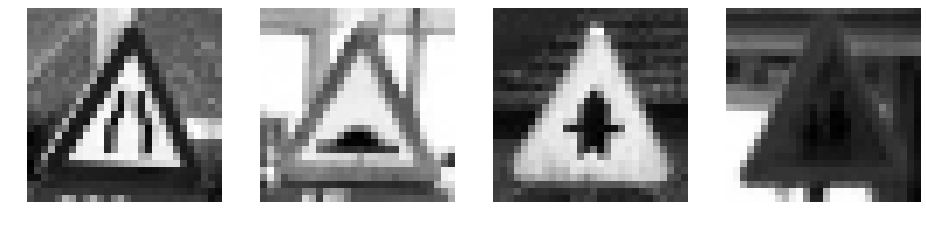

In [8]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [9]:
data.sample(10)

,image_path,shape,stype,pole,angle
2378,./trafficsigns_dataset/round/noparking/01826_0...,round,noparking,01826,00002
971,./trafficsigns_dataset/round/noentry/00048_000...,round,noentry,00048,00000
1161,./trafficsigns_dataset/round/noentry/01246_000...,round,noentry,01246,00002
979,./trafficsigns_dataset/round/noentry/01150_000...,round,noentry,01150,00000
1991,./trafficsigns_dataset/round/traveldirection/0...,round,traveldirection,00588,00000
3393,./trafficsigns_dataset/square/crossing/00151_0...,square,crossing,00151,00001
1070,./trafficsigns_dataset/round/noentry/00560_000...,round,noentry,00560,00001
3051,./trafficsigns_dataset/square/laneend/01467_00...,square,laneend,01467,00001
1403,./trafficsigns_dataset/round/speed/01807_00000...,round,speed,01807,00000
3087,./trafficsigns_dataset/square/laneend/00607_00...,square,laneend,00607,00001


In [10]:
sh = {'round':0, 'triangle':1, 'square':2, 'diamond':3, 'hex':4}
t = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9, 'continue':10, 'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}
data['shape_num'] = data['shape'].map(sh, na_action='ignore')
data['stype_num'] = data['stype'].map(t, na_action='ignore')
data['angle'] = pd.to_numeric(data['angle'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 7 columns):
image_path    3699 non-null object
shape         3699 non-null object
stype         3699 non-null object
pole          3699 non-null object
angle         3699 non-null int64
shape_num     3699 non-null int64
stype_num     3699 non-null int64
dtypes: int64(3), object(4)
memory usage: 202.4+ KB


In [11]:
data.sample(10)

,image_path,shape,stype,pole,angle,shape_num,stype_num
1894,./trafficsigns_dataset/round/trafficdirective/...,round,trafficdirective,01181,1,0,8
477,./trafficsigns_dataset/triangle/warning/00270_...,triangle,warning,00270,1,1,15
1901,./trafficsigns_dataset/round/trafficdirective/...,round,trafficdirective,01151,2,0,8
2632,./trafficsigns_dataset/round/bicycle/00395_000...,round,bicycle,00395,2,0,2
3356,./trafficsigns_dataset/square/crossing/01887_0...,square,crossing,01887,2,2,11
2235,./trafficsigns_dataset/round/noparking/00767_0...,round,noparking,00767,0,0,5
361,./trafficsigns_dataset/triangle/warning/00618_...,triangle,warning,00618,2,1,15
2820,./trafficsigns_dataset/diamond/rightofway/0195...,diamond,rightofway,01956,0,3,0
3270,./trafficsigns_dataset/square/continue/01056_0...,square,continue,01056,2,2,10
2122,./trafficsigns_dataset/round/limitedtraffic/00...,round,limitedtraffic,00040,0,0,3


In [12]:
X = data['image_path']
Y_shape = data['shape_num']
Y_type = data['stype_num']
print(X.shape)
print(Y_shape.unique())
print(Y_type.unique())

(3699,)
[1 0 3 4 2]
[15 14  4  7  6  8  9  3  5  2  0  1 12 10 11 13]


### 1.3 Evaluation Framework 

In [13]:
train_df, validation_df = train_test_split(data, test_size=0.2)
train_df, test_df = train_test_split(train_df, test_size=0.25)
print('Train size: {}, Validate size: {} Test size: {}'.format(train_df.shape, validation_df.shape, test_df.shape))

N_train_images = train_df.shape[0]
N_val_images = validation_df.shape[0]
N_test_images = test_df.shape[0]

Train size: (2219, 7), Validate size: (740, 7) Test size: (740, 7)


## 2. Data Modelling

### 2.1 Sign Shape Classification

In [14]:
shape_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
shape_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
shape_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

shape_train_generator = shape_train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

shape_validation_generator = shape_val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')


batch_size_t = 1

shape_test_generator = shape_test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [15]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

In [16]:
def train_shape_model(model_, num_epoch, verbose):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in shape_train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, shape_validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [17]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

#### 2.1.1 First Model

In [18]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

shape_model = Sequential()
shape_model.add(Flatten(input_shape=(28, 28, 3)))
shape_model.add(Dense(64))
shape_model.add(Activation('relu'))
shape_model.add(Dense(5))
shape_model.add(Activation('softmax'))


# Compile model
shape_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[categorical_accuracy])
shape_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                150592    
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 150,917
Trainable params: 150,917
Non-trainable params: 0
_________________________________________________________________


In [19]:
res = train_shape_model(shape_model, num_epoch=20, verbose=False)

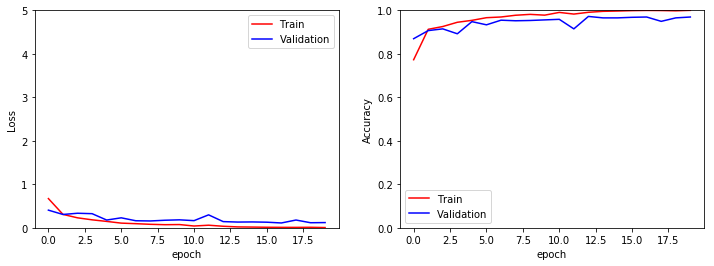

In [20]:
plot_results(res)

#### 2.1.2 Do some regularization

Lets add some ridge penalty and create a new model

In [21]:
# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64,kernel_regularizer=regularizers.l2(0.01))(x) # reg for weight matrix 1
h = Activation('sigmoid', name='hidden_layer')(h)

# Output layer
out_ = Dense(5,kernel_regularizer=regularizers.l2(0.01))(h) # reg for weight matrix 2
out_ = Activation('softmax')(out_)

# Define model
shape_model_reg = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
shape_model_reg.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


shape_model_reg.summary()

# Creating a model for feature vizualization (will be explained later)
hidden_features = Model(inputs=input_, outputs=h)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
hidden_layer (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0     

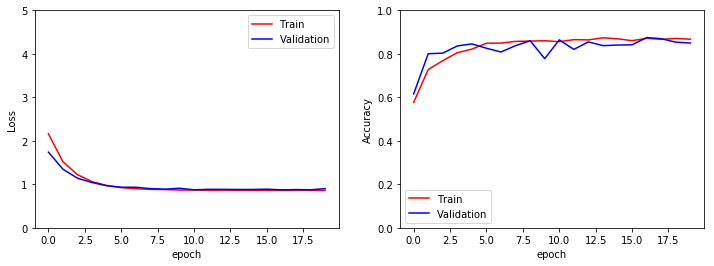

In [22]:
res = train_shape_model(shape_model_reg, num_epoch=20, verbose=False)
plot_results(res)

#### 2.1.3 Try some dropout

Lets create a model with dropput and see if that can also help with overfitting (no regularization)

In [23]:
# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x) 
h = Activation('sigmoid')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(5)(h) 
out_ = Activation('softmax')(out_)

# Define model
shape_model_drop = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
shape_model_drop.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


shape_model_drop.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325 

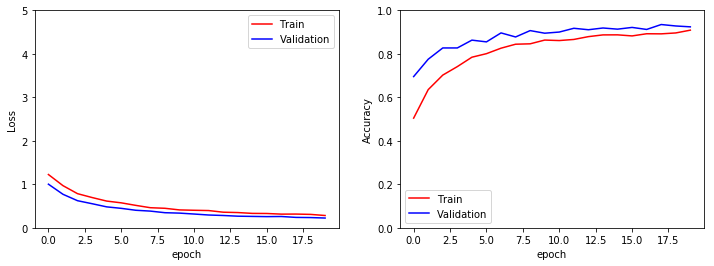

In [24]:
res = train_shape_model(shape_model_drop, num_epoch=20, verbose=False)
plot_results(res)

#### 2.1.4 Extract the hidden layer features and vizualize

For extracting features we can generate a new model with the same input as the original model and with the output from the desired layer. I have done this for the regularized model. Check the code block of the regularized model.  

In [25]:
#print layer names
for layer in hidden_features.layers:
    print(layer.name)


def extract_hidden_features(model_, generator_, N_images): 
    batches = 0

    features = []
    inputs = []
    y_ = []

    # iterate over each batch
    for x,y in generator_:
        hf = model_.predict(x) 
        for h in hf:
            features.append(h)
        for yy in y:
            y_.append(np.argmax(yy))
        for xx in x:
            inputs.append(xx.reshape(-1,))

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 
    features = np.asarray(features)
    y = np.asarray(y_)
    inputs = np.asarray(inputs)
    
    return inputs, y, features

input_1
lambda
flatten_1
dense_2
hidden_layer


Text(0.5, 1.0, 'Input Embedding')

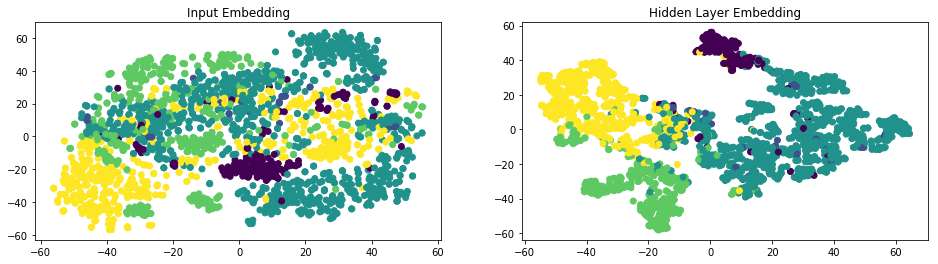

In [27]:
inputs, y, features = extract_hidden_features(hidden_features, shape_train_generator, N_train_images)

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

Now lets plot for test data

Text(0.5, 1.0, 'Input Embedding')

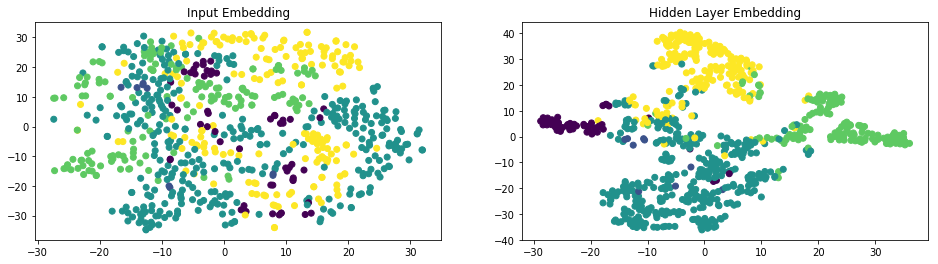

In [28]:
inputs, y, features = extract_hidden_features(hidden_features, shape_validation_generator, N_val_images)

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

What does the above two plots tell you about overfitting?

#### 2.1.5 Try a deep CNN network

One important method that can be used to prevent CNN from overfitting to the training data, one can augment the images randomly. The image data generator can apply random image augmentations to data like: rotations, translation etc. Lets do some random rotations and translations. Note that Augmentations are not usually applied to test data.  

In [30]:
shape_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
batch_size = 16

shape_train_generator = shape_train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.


In [31]:
shape_model_cnn = Sequential()
shape_model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
shape_model_cnn.add(Activation('relu'))
shape_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

shape_model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
shape_model_cnn.add(Activation('relu'))
# model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

shape_model_cnn.add(Conv2D(64, (3, 3)))
shape_model_cnn.add(Activation('relu'))
shape_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

shape_model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
shape_model_cnn.add(Dense(64))
shape_model_cnn.add(Activation('relu'))
shape_model_cnn.add(Dropout(0.5))
shape_model_cnn.add(Dense(5))
shape_model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
shape_model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

shape_model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_7 (Activation)    (None, 9, 9, 64)         

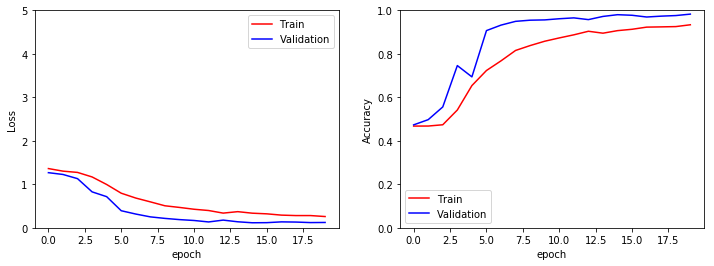

In [32]:
res = train_shape_model(shape_model_cnn, num_epoch=20, verbose=False)
plot_results(res)

#### 2.1.6 Predict on random images from test set

Since we dont have an independet test set for this data, we will test on the validation set. This is clearly not a good stratergy. 

First we will create a data generator to get the test data

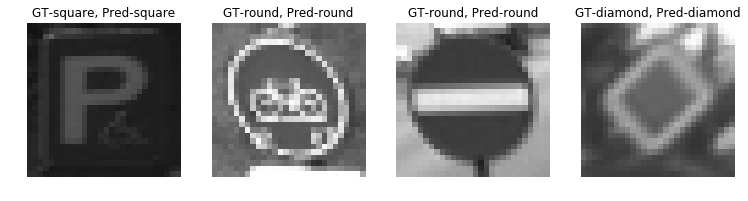

In [33]:
shape_d_test_inv = {0: 'diamond', 1: 'hex', 2: 'round', 3: 'square', 4: 'triangle'}
plt.figure(figsize=(16,4))
batches = 0
for x,y in shape_test_generator:
        batches = batches + 1
        y_hat = shape_model_cnn.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(shape_d_test_inv[np.argmax(y[0])], shape_d_test_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [34]:
print(shape_d_test_inv)
print(sh)

{0: 'diamond', 1: 'hex', 2: 'round', 3: 'square', 4: 'triangle'}
{'round': 0, 'triangle': 1, 'square': 2, 'diamond': 3, 'hex': 4}


### 2.2 Sign Type Classification

In [35]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

type_train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="stype",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

type_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="stype",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')


batch_size_t = 1

type_test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='./',
        x_col="image_path",
        y_col="stype",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [36]:
def train_type_model(model_, num_epoch, verbose):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in type_train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, type_validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

#### 2.2.1 First model

In [37]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

type_model = Sequential()
type_model.add(Flatten(input_shape=(28, 28, 3)))
type_model.add(Dense(64))
type_model.add(Activation('relu'))
type_model.add(Dense(16))
type_model.add(Activation('softmax'))


# Compile model
type_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[categorical_accuracy])
type_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                150592    
_________________________________________________________________
activation_10 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                1040      
_________________________________________________________________
activation_11 (Activation)   (None, 16)                0         
Total params: 151,632
Trainable params: 151,632
Non-trainable params: 0
_________________________________________________________________


In [38]:
res = train_type_model(type_model, num_epoch=20, verbose=False)

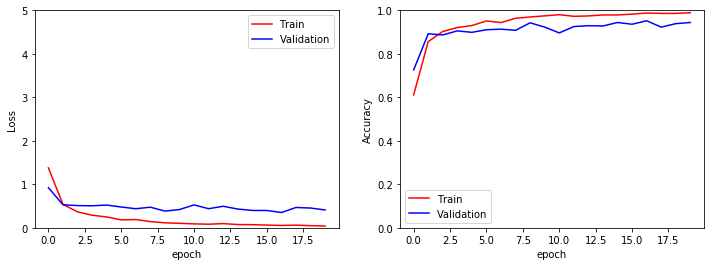

In [39]:
plot_results(res)

#### 2.2.2 Do some regularization

Lets add some ridge penalty and create a new model

In [42]:
# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64,kernel_regularizer=regularizers.l2(0.01))(x) # reg for weight matrix 1
h = Activation('sigmoid', name='hidden_layer')(h)

# Output layer
out_ = Dense(16,kernel_regularizer=regularizers.l2(0.01))(h) # reg for weight matrix 2
out_ = Activation('softmax')(out_)

# Define model
type_model_reg = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
type_model_reg.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


type_model_reg.summary()

# Creating a model for feature vizualization (will be explained later)
hidden_features = Model(inputs=input_, outputs=h)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
hidden_layer (Activation)    (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_13 (Activation)   (None, 16)                0   

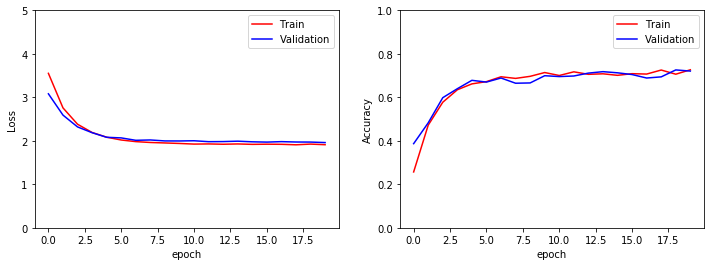

In [43]:
res = train_type_model(type_model_reg, num_epoch=20, verbose=False)
plot_results(res)

#### 2.2.3 Try some dropout

Lets create a model with dropput and see if that can also help with overfitting (no regularization)

In [44]:
# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x) 
h = Activation('sigmoid')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(16)(h) 
out_ = Activation('softmax')(out_)

# Define model
type_model_drop = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
type_model_drop.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


type_model_drop.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_14 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                1040

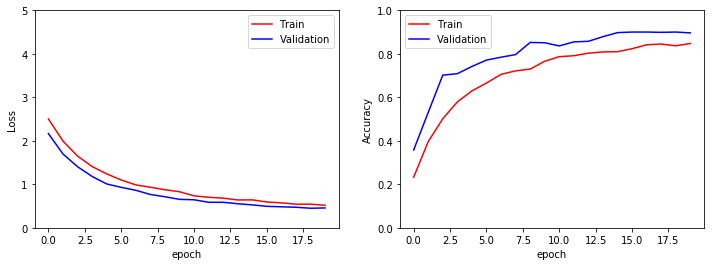

In [45]:
res = train_type_model(type_model_drop, num_epoch=20, verbose=False)
plot_results(res)

#### 2.2.4 Extract the hidden layer features and vizualize

For extracting features we can generate a new model with the same input as the original model and with the output from the desired layer. I have done this for the regularized model. Check the code block of the regularized model.

In [46]:
#print layer names
for layer in hidden_features.layers:
    print(layer.name)


def extract_hidden_features(model_, generator_, N_images): 
    batches = 0

    features = []
    inputs = []
    y_ = []

    # iterate over each batch
    for x,y in generator_:
        hf = model_.predict(x) 
        for h in hf:
            features.append(h)
        for yy in y:
            y_.append(np.argmax(yy))
        for xx in x:
            inputs.append(xx.reshape(-1,))

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 
    features = np.asarray(features)
    y = np.asarray(y_)
    inputs = np.asarray(inputs)
    
    return inputs, y, features

input_4
lambda_3
flatten_6
dense_12
hidden_layer


Text(0.5, 1.0, 'Input Embedding')

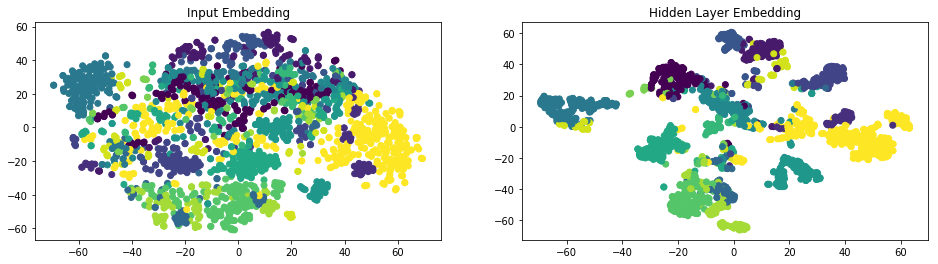

In [47]:
inputs, y, features = extract_hidden_features(hidden_features, type_train_generator, N_train_images)

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

Text(0.5, 1.0, 'Input Embedding')

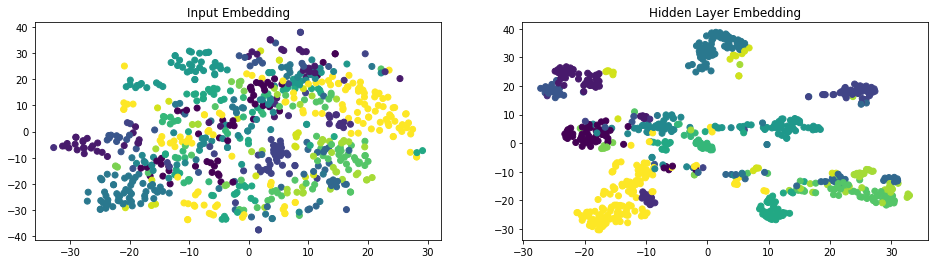

In [48]:
inputs, y, features = extract_hidden_features(hidden_features, type_validation_generator, N_val_images)

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

#### 2.1.5 Try a deep CNN network

One important method that can be used to prevent CNN from overfitting to the training data, one can augment the images randomly. The image data generator can apply random image augmentations to data like: rotations, translation etc. Lets do some random rotations and translations. Note that Augmentations are not usually applied to test data.  

In [49]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)

batch_size = 16

type_train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="stype",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.


In [50]:
type_model_cnn = Sequential()
type_model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
type_model_cnn.add(Activation('relu'))
type_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

type_model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
type_model_cnn.add(Activation('relu'))
# model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

type_model_cnn.add(Conv2D(64, (3, 3)))
type_model_cnn.add(Activation('relu'))
type_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

type_model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
type_model_cnn.add(Dense(64))
type_model_cnn.add(Activation('relu'))
type_model_cnn.add(Dropout(0.5))
type_model_cnn.add(Dense(16))
type_model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
type_model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

type_model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
activation_16 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_18 (Activation)   (None, 9, 9, 64)         

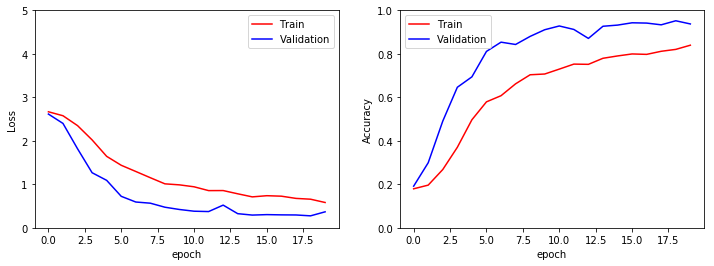

In [51]:
res = train_type_model(type_model_cnn, num_epoch=20, verbose=False)
plot_results(res)

#### 2.1.6 Predict on random images from test set

Since we dont have an independet test set for this data, we will test on the validation set. This is clearly not a good stratergy. 

First we will create a data generator to get the test data

0
4
3
13
0
10
8
15
11


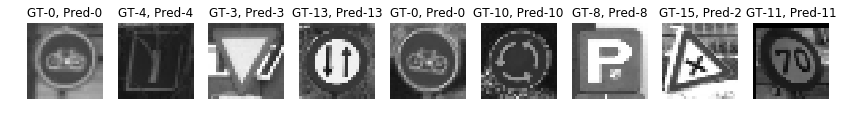

In [52]:
type_d_test_inv = {0: 'rightofway', 1: 'continue', 2: 'bicycle', 3: 'limitedtraffic', 4: 'laneend', 5: 'noparking', 6: 'roundabout', 7: 'speed', 8: 'trafficdirective', 9: 'traveldirection', 10: 'continue', 11: 'crossing', 12: 'laneend', 13: 'parking', 14: 'traveldirection', 15: 'warning'}
plt.figure(figsize=(16,4))
batches = 0
for x,y in type_test_generator:
        batches = batches + 1
        y_hat = type_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 10:
            print(np.argmax(y[0]))
            plt.subplot(1,10,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(np.argmax(y[0]), np.argmax(y_hat[0])))
            
        else:
            break
        
        plt.axis('off')

In [54]:
print(type_d_test_inv)
print(t)

{0: 'rightofway', 1: 'continue', 2: 'bicycle', 3: 'limitedtraffic', 4: 'laneend', 5: 'noparking', 6: 'roundabout', 7: 'speed', 8: 'trafficdirective', 9: 'traveldirection', 10: 'continue', 11: 'crossing', 12: 'laneend', 13: 'parking', 14: 'traveldirection', 15: 'warning'}
{'rightofway': 0, 'stop': 1, 'bicycle': 2, 'limitedtraffic': 3, 'noentry': 4, 'noparking': 5, 'roundabout': 6, 'speed': 7, 'trafficdirective': 8, 'traveldirection': 9, 'continue': 10, 'crossing': 11, 'laneend': 12, 'parking': 13, 'giveway': 14, 'warning': 15}


## 3.Independent Evaluation